## Deadline

Wednesday, November 22, 2017, 11:59PM

## Important notes

- When you push your Notebook to GitHub, all the cells must already have been evaluated.
- Don't forget to add a textual description of your thought process and of any assumptions you've made.
- Please write all your comments in English, and use meaningful variable names in your code.

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
import seaborn as sns
%matplotlib inline


## Question 1: Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 5 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to brush up your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [56]:
path='./lalonde.csv'
df=pd.read_csv(path)
df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

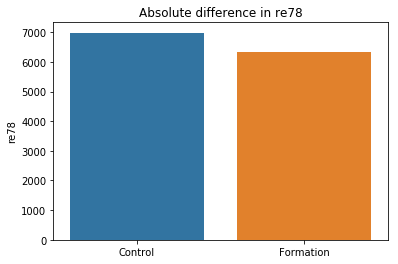

In [57]:
def plot_absolute_salary(df):
    gb_treat_mean=df.groupby('treat').mean()
    plt.title('Absolute difference in re78')
    sns.barplot(['Control', 'Formation'], gb_treat_mean.re78)
plot_absolute_salary(df)

__A naive analysis of this result would be that the formation leads to a smaller income, because the non treated group has a greater salary than the treated one. Of course this analysis is wrong, because there are other factors to consider, such as the salary before treatment, the education, and most importantly the bias induced by the category of people who choosed to follow the treatment.__

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

__ A better approach would need us to take into account the other parameters that have an influence on the final salary, and compare it with the population that followed the treatment__

__We will also evaluate the relative salary increase before and after the treatment between the control group and the treated group to get a better appreciation of the treatment impact.__

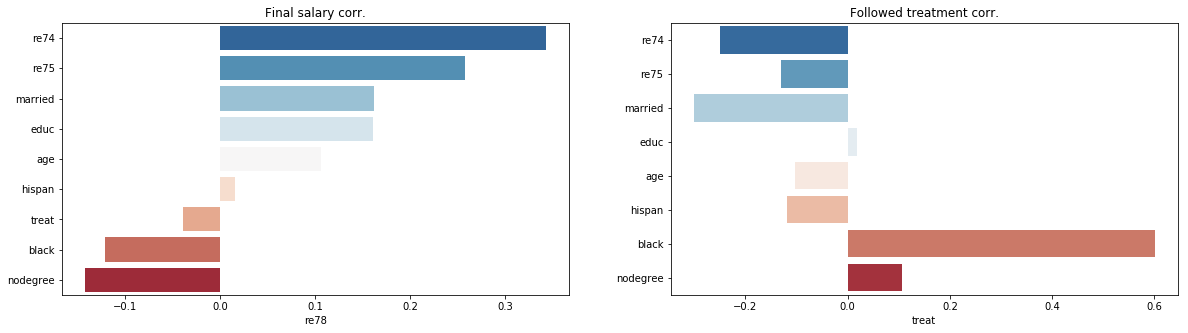

In [58]:
def plot_correlation(df):
    correlation=df.corr()

    fig = plt.figure(figsize=(20,5))
    ax1 = fig.add_subplot(121)
    locs, labels = plt.xticks()
    plt.title('Final salary corr.')
    ax2 = fig.add_subplot(122)
    locs, labels = plt.xticks()
    plt.title('Followed treatment corr.')


    s=correlation.re78
    s.drop('re78', inplace=True)
    sor=s.sort_values(ascending=False)
    sns.barplot(sor,sor.index, palette="RdBu_r",ax=ax1)

    s2=correlation.treat
    s2.drop('re78', inplace=True)
    s2=s2.reindex(sor.index)
    s2.drop('treat',inplace=True)
    sns.barplot(s2,s2.index, palette="RdBu_r",ax=ax2)
plot_correlation(df)

__ These barplots shows that the correlation between the treatment and the final salary is lowest than other parameters, like the degree. The population on which the treatment has been applied is also more represented for the negative correlations with the final salary__

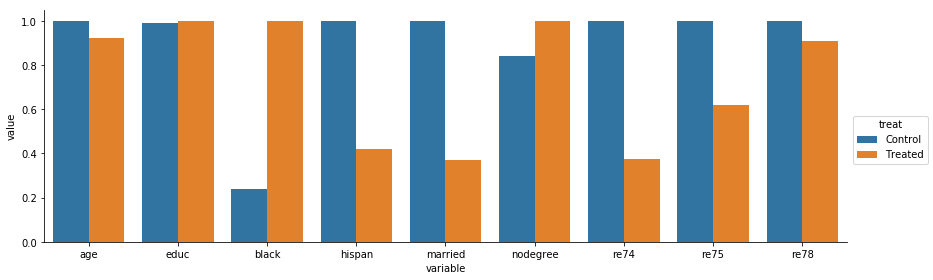

In [59]:
def plot_group_rep(df):
    gb=df.groupby('treat').mean()
    #gb['treat']=pd.Series(['Control','Treated'])
    norm=gb.apply(lambda x:x/x.max(), axis=0)
    norm['treat']=pd.Series(['Control','Treated'])
    mel=pd.melt(norm,id_vars='treat')
    fig = plt.figure(figsize=(60,5))
    sns.factorplot(x='variable',y='value',hue='treat',data=mel,kind='bar',size=4,aspect=3)
plot_group_rep(df)

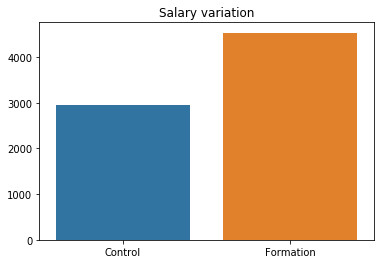

In [5]:
def plot_relative_salary(df):
    control=df[df.treat==0]
    treated=df[df.treat==1]
    control_increase=(control.re78-(control.re74+control.re75)/2).mean()
    treated_increase=(treated.re78-(treated.re74+treated.re75)/2).mean()
    plt.title('Salary variation')
    sns.barplot(['Control','Formation'], [control_increase,treated_increase])
plot_relative_salary(df)

__ Simply by comparing the salary increase before and after the formation with the control group, we could have an opposite conclusion than with the naive approach. Note that the increase also takes into account the unemployed people who found a job after the study__

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

__Before fitting, we select the features determining the propensity. As we want to only take into account the pre-treatment features, we drop the final income and the treatment column.
The prediction output being for each class (0 or 1 for treatment), we only take into account the treatment probability column, as the other is its complementary__

In [6]:
logistic=linear_model.LogisticRegression()

features=df.columns.drop(['re78', 'id', 'treat'])
X=pd.get_dummies(df[features])
y=df['treat']

logistic.fit(X,y)
pred=logistic.predict_proba(X)
logistic.classes_
proba_treat=pred[:,1]
s=pd.Series(proba_treat.tolist())
df['proba_treat']=s
df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,proba_treat
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [8]:
import networkx as nx
from networkx.algorithms import bipartite
G=nx.Graph()

control=df[df.treat==0]
treat=df[df.treat==1]
G.add_nodes_from(control.id,bipartite=0)
G.add_nodes_from(treat.id,bipartite=1)

for id1 in control.index:
    for id2 in treat.index:
        c1=control.loc[id1].id
        c2=treat.loc[id2].id
        w=1/(1+abs(control.loc[id1].proba_treat-treat.loc[id2].proba_treat))
        G.add_edge(c1,c2,weight=w)
        
match=nx.max_weight_matching(G)

In [47]:
new_df=pd.DataFrame()
for idx in treat.index:
    match_subject=match[treat.loc[idx].id]
    new_df=new_df.append(treat.loc[idx])
    new_df=new_df.append(control[control.id==match_subject])
new_df.head(6)

,age,black,educ,hispan,id,married,nodegree,proba_treat,re74,re75,re78,treat
0,37.0,1.0,11.0,0.0,NSW1,1.0,1.0,0.443350,0.0000,0.0,9930.046,1.0
552,40.0,1.0,11.0,0.0,PSID368,1.0,1.0,0.438326,0.0000,0.0,0.000,0.0
1,22.0,0.0,9.0,1.0,NSW2,0.0,1.0,0.144660,0.0000,0.0,3595.894,1.0
579,53.0,0.0,12.0,0.0,PSID395,0.0,0.0,0.143760,0.0000,0.0,0.000,0.0
2,30.0,1.0,12.0,0.0,NSW3,0.0,0.0,0.722355,0.0000,0.0,24909.450,1.0
536,24.0,1.0,12.0,0.0,PSID352,0.0,0.0,0.721966,566.2281,0.0,2284.565,0.0


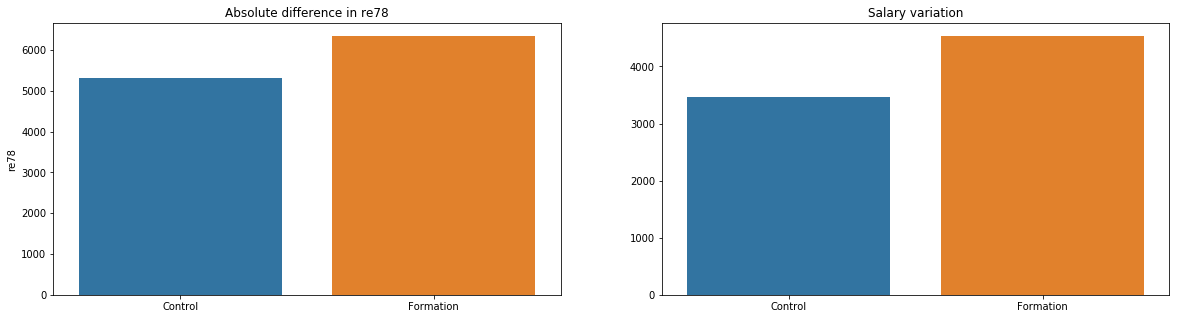

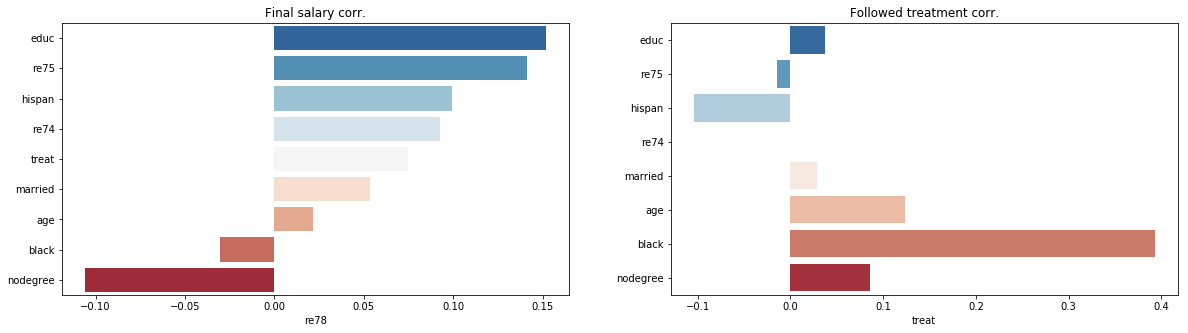

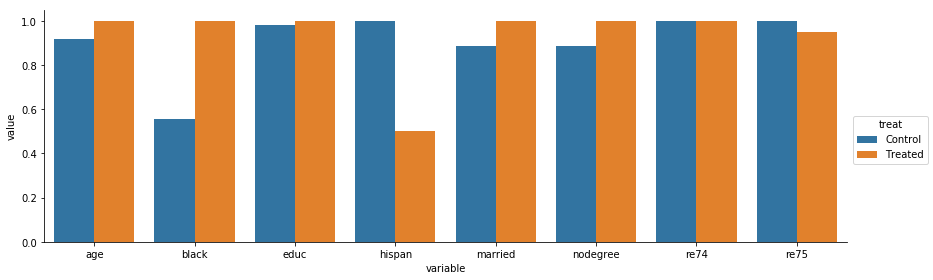

In [54]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(121)
plot_absolute_salary(new_df)
x2=fig.add_subplot(122)
plot_relative_salary(new_df)
temp_df=new_df.drop(['proba_treat'],axis=1)
plot_correlation(temp_df)
temp_df=new_df.drop(['re78','proba_treat'],axis=1)
plot_group_rep(temp_df)

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.

#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?


## Question 2: Applied ML

We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!

1. Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequencyâ€“inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).


2. Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.

